In [22]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import random
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
def make_dir(base_path, level):
    level_dir = f'{base_path}{level}level'
    if not os.path.exists(level_dir):
        os.mkdir(level_dir)
    train_image_dir = os.path.join(level_dir,'train_image/')
    train_mask_dir = os.path.join(level_dir,'train_mask/')

    val_image_dir = os.path.join(level_dir,'val_image/')
    val_mask_dir = os.path.join(level_dir,'val_mask/')

    test_image_dir = os.path.join(level_dir,'test_image/')
    test_mask_dir = os.path.join(level_dir,'test_mask/')

    if not os.path.exists(train_image_dir):
        os.mkdir(train_image_dir)
    if not os.path.exists(train_mask_dir):
        os.mkdir(train_mask_dir)
    if not os.path.exists(val_image_dir):
        os.mkdir(val_image_dir)
    if not os.path.exists(val_mask_dir):
        os.mkdir(val_mask_dir)    
    if not os.path.exists(test_image_dir):
        os.mkdir(test_image_dir)
    if not os.path.exists(test_mask_dir):
        os.mkdir(test_mask_dir)
    return(train_image_dir, train_mask_dir, val_image_dir, val_mask_dir, test_image_dir, test_mask_dir)

In [26]:
base_path = '/content/'
train_image_dir, train_mask_dir, val_image_dir, val_mask_dir, test_image_dir, test_mask_dir = make_dir(base_path, level = 'multi_')

In [27]:
train_image_dir

'/content/multi_level/train_image/'

In [28]:
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/multi_level/train_image.zip' -d /content/multi_level/train_image/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/multi_level/val_image.zip' -d /content/multi_level/val_image/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/multi_level/test_image.zip' -d /content/multi_level/test_image/

replace /content/multi_level/train_image/normal/slide084_train_high_res_image_normal_5523.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace /content/multi_level/val_image/normal/slide023_val_low_res_image_normal_305.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace /content/multi_level/test_image/normal/slide016_test_high_res_image_normal_39.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
!cp '/content/drive/MyDrive/Applied Deep Learning/project/multi_level/multi_level_train_data.txt' /content/
!cp '/content/drive/MyDrive/Applied Deep Learning/project/multi_level/multi_level_val_data.txt' /content/
!cp '/content/drive/MyDrive/Applied Deep Learning/project/multi_level/multi_level_test_data.txt' /content/

In [29]:
train_df = pd.read_csv('/content/multi_level_train_data.txt', header = None)
val_df = pd.read_csv('/content/multi_level_val_data.txt', header = None)
test_df = pd.read_csv('/content/multi_level_test_data.txt', header = None)
cols = ['Low Res Image Paths', 'High Res Image Paths', 'Low Res Xoffset', 'Low Res Yoffset', 'High Res Xoffset', 
                                                     'High Res Yoffset', 'Labels', 'slide code', 'Low Res Level', 'High Res Level']
train_df.columns, val_df.columns, test_df.columns = cols, cols, cols

train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

train_df['Labels'] = train_df['Labels'].astype(str)
val_df['Labels'] = val_df['Labels'].astype(str)
test_df['Labels'] = test_df['Labels'].astype(str)

In [30]:
train_df.head()

,Low Res Image Paths,High Res Image Paths,Low Res Xoffset,Low Res Yoffset,High Res Xoffset,High Res Yoffset,Labels,slide code,Low Res Level,High Res Level
0,/content/multi_level/train_image/normal/slide0...,/content/multi_level/train_image/normal/slide0...,3328,8064,6804,16276,0,1,4,3
1,/content/multi_level/train_image/normal/slide0...,/content/multi_level/train_image/normal/slide0...,3456,7808,7060,15764,0,1,4,3
2,/content/multi_level/train_image/normal/slide0...,/content/multi_level/train_image/normal/slide0...,6144,2304,12436,4756,0,96,4,3
3,/content/multi_level/train_image/tumor/slide07...,/content/multi_level/train_image/tumor/slide07...,2304,4096,4756,8340,1,78,4,3
4,/content/multi_level/train_image/normal/slide0...,/content/multi_level/train_image/normal/slide0...,3456,3840,7060,7828,0,12,4,3


In [31]:
train_df.shape

(6440, 10)

In [107]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale = 1./255)
def data_generator_aug(train_datagen, df, train_image_dir):
    train_generator1 = train_datagen.flow_from_dataframe(
        dataframe = df,
        directory = train_image_dir,
        x_col = 'Low Res Image Paths',
        y_col = 'Labels',
        target_size = (IMG_SIZE, IMG_SIZE),
        batch_size = batch_size,
        class_mode = 'binary',
        shuffle=False
    )
    train_generator2 = train_datagen.flow_from_dataframe(
        dataframe = df,
        directory = train_image_dir,
        x_col = 'High Res Image Paths',
        y_col = 'Labels',
        target_size = (IMG_SIZE, IMG_SIZE),
        batch_size = batch_size,
        class_mode = 'binary',
        shuffle=False
    )
    while True:
        level1, label = next(train_generator1)
        level2 = next(train_generator2)[0]
        yield([level1, level2], label)

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# def data_generator_aug(train_df, val_df, test_df, resolution = 'Low Res Image Paths'):
#     # train set
#     train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         rotation_range=90,
#         # width_shift_range=0.2,
#         # height_shift_range=0.2,
#         # shear_range=0.2,
#         # zoom_range=0.2,
#         horizontal_flip=True)
#     test_datagen = ImageDataGenerator(rescale = 1./255)
#     # train set
#     train_generator = train_datagen.flow_from_dataframe(
#         dataframe = train_df,
#         directory = train_image_dir,
#         x_col = resolution,
#         y_col = 'Labels',
#         target_size = (IMG_SIZE, IMG_SIZE),
#         batch_size = batch_size,
#         class_mode = 'binary',
#         shuffle=False
#     )
#     validation_generator = test_datagen.flow_from_dataframe(
#         dataframe = val_df,
#         directory = val_image_dir,
#         x_col = resolution,
#         y_col = 'Labels',
#         target_size = (IMG_SIZE, IMG_SIZE),
#         batch_size = batch_size,
#         class_mode = 'binary',
#         shuffle=False
#     )

#     for data_batch, labels_batch in train_generator:
#         print('Train data: ')
#         print('data batch shape:', data_batch.shape)
#         print('labels batch shape:', labels_batch.shape)
#         break

#     for data_batch, labels_batch in validation_generator:
#         print('\n')
#         print('Validation data: ')
#         print('data batch shape:', data_batch.shape)
#         print('labels batch shape:', labels_batch.shape)
#         break
#     # test set
#     test_generator = test_datagen.flow_from_dataframe(
#         dataframe = test_df,
#         directory = test_image_dir,
#         x_col = resolution,
#         y_col = 'Labels',
#         target_size = (IMG_SIZE, IMG_SIZE),
#         batch_size = batch_size,
#         class_mode = 'binary',
#         shuffle = False
#     )
#     return(train_generator, validation_generator, test_generator)

# Multi-level Model

In [108]:
IMG_SIZE = 299
batch_size = 8
multi_train_generator = data_generator_aug(train_datagen, train_df, train_image_dir)
multi_val_generator = data_generator_aug(test_datagen, val_df, val_image_dir)
multi_test_generator = data_generator_aug(test_datagen, test_df, test_image_dir)

In [34]:

# print('Low Res Images')
# level4_train_generator, level4_validation_generator, level4_test_generator = data_generator_aug(train_df, val_df, test_df)
# print()
# print('High Res Images')
# level3_train_generator, level3_validation_generator, level3_test_generator = data_generator_aug(train_df, val_df, test_df, 'High Res Image Paths')

In [ ]:
# def combine_generator(gen1, gen2):
#     while True:
#         yield([next(gen1)[0], next(gen2)[0]], next(gen1)[1])

In [ ]:
# multi_train_generator = combine_generator(level3_train_generator, level4_train_generator)
# multi_val_generator = combine_generator(level3_validation_generator, level4_validation_generator)
# multi_test_generator = combine_generator(level3_test_generator, level4_test_generator)

In [99]:
IMG_SIZE = 299
vgg_base_1 = tf.keras.applications.VGG16(
            include_top = False,
            weights = 'imagenet',
            input_shape = (IMG_SIZE, IMG_SIZE, 3),
            pooling = None,
            classes = 2,
            classifier_activation = 'softmax',
        )
vgg_base_2 = tf.keras.applications.VGG16(
            include_top = False,
            weights = 'imagenet',
            input_shape = (IMG_SIZE, IMG_SIZE, 3),
            pooling = None,
            classes = 2,
            classifier_activation = 'softmax',
        )
vgg_base_1.trainable = False
vgg_base_2.trainable = False


high_res_level_input = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
low_res_level_input = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# high resolution level
high_res_vgg = tf.keras.Sequential([
    vgg_base_1,
    tf.keras.layers.GlobalAveragePooling2D(),
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(128, activation='relu')
])
high_res_vgg_output = high_res_vgg(high_res_level_input)

# low resolution level
low_res_vgg = tf.keras.Sequential([
    vgg_base_2,
    tf.keras.layers.GlobalAveragePooling2D(),
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(128, activation='relu'),
])
low_res_vgg_output = low_res_vgg(low_res_level_input)

# concatenate two output layers as input
concatenated_input = tf.keras.layers.concatenate([high_res_vgg_output, low_res_vgg_output], axis = -1)
flattened = tf.keras.layers.Flatten()(concatenated_input)

output = tf.keras.layers.Dense(128, activation="relu")(flattened)
output = tf.keras.layers.Dropout(0.4)(output)
output = tf.keras.layers.Dense(2, activation="softmax")(output)

vgg_multi_resolution_model = tf.keras.Model(inputs=[high_res_level_input, low_res_level_input], outputs=output)
vgg_multi_resolution_model.summary()

vgg_multi_resolution_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                                   loss = 'sparse_categorical_crossentropy',
                                   metrics = ['accuracy'])

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential_14 (Sequential)      (None, 512)          14714688    input_31[0][0]                   
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 512)          14714688    input_32[0][0]                   
____________________________________________________________________________________________

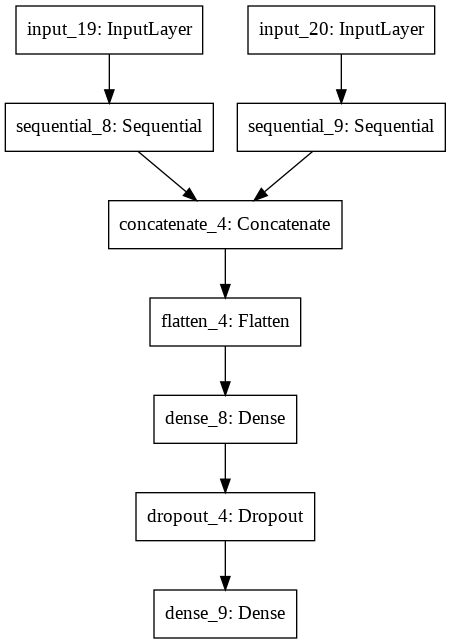

In [71]:
tf.keras.utils.plot_model(vgg_multi_resolution_model)

In [100]:
if not os.path.exists('/content/checkpoint'):
  os.mkdir('/content/checkpoint')
if not os.path.exists('/content/checkpoint/VGG'):
  os.mkdir('/content/checkpoint/VGG')
multi_vgg_checkpoint_path = '/content/checkpoint/VGG/multi_level_weights-improvement-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.hdf5'
vgg_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(multi_vgg_checkpoint_path, 
                                                                    monitor='val_loss', 
                                                                    save_best_only=True, 
                                                                    mode='auto')

vgg_early_stop_callback = tf.keras.callbacks.EarlyStopping(
                              monitor='val_loss', min_delta=0, patience=10)

In [109]:
for data_batch, labels_batch in multi_train_generator:
    print('Train data: ')
    print('data batch shape:', len(data_batch))
    print('data batch', data_batch[0].shape)
    print('data batch2', data_batch[1].shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 6440 validated image filenames belonging to 2 classes.
Found 6440 validated image filenames belonging to 2 classes.
Train data: 
data batch shape: 2
data batch (8, 299, 299, 3)
data batch2 (8, 299, 299, 3)
labels batch shape: (8,)


In [110]:
for data_batch, labels_batch in multi_val_generator:
    print('Train data: ')
    print('data batch shape:', len(data_batch))
    print('data batch', data_batch[0].shape)
    print('data batch2', data_batch[1].shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 1458 validated image filenames belonging to 2 classes.
Found 1458 validated image filenames belonging to 2 classes.
Train data: 
data batch shape: 2
data batch (8, 299, 299, 3)
data batch2 (8, 299, 299, 3)
labels batch shape: (8,)


In [111]:
steps_per_epoch = train_df.shape[0] // batch_size
validation_steps = val_df.shape[0] // batch_size
# steps_per_epoch = 6400 // batch_size
# validation_steps = 1400 // batch_size

In [112]:
epochs = 10
multi_level_vgg_history = vgg_multi_resolution_model.fit(multi_train_generator, 
                                                          epochs = epochs,
                                                          steps_per_epoch = steps_per_epoch,
                                                          validation_steps = validation_steps,
                                                          validation_data=multi_val_generator,
                                                          callbacks=[vgg_checkpoint_callback, 
                                                                    vgg_early_stop_callback])

Epoch 1/10
805/805 [==============================] - 299s 372ms/step - loss: 0.2345 - accuracy: 0.9179 - val_loss: 0.0781 - val_accuracy: 0.9828
Epoch 2/10
805/805 [==============================] - 291s 362ms/step - loss: 0.1910 - accuracy: 0.9339 - val_loss: 0.0676 - val_accuracy: 0.9828
Epoch 3/10
805/805 [==============================] - 276s 344ms/step - loss: 0.1756 - accuracy: 0.9424 - val_loss: 0.0706 - val_accuracy: 0.9793
Epoch 4/10
805/805 [==============================] - 301s 375ms/step - loss: 0.1707 - accuracy: 0.9429 - val_loss: 0.0666 - val_accuracy: 0.9793
Epoch 5/10
805/805 [==============================] - 291s 361ms/step - loss: 0.1578 - accuracy: 0.9469 - val_loss: 0.0663 - val_accuracy: 0.9786
Epoch 6/10
805/805 [==============================] - 296s 369ms/step - loss: 0.1591 - accuracy: 0.9464 - val_loss: 0.0678 - val_accuracy: 0.9786
Epoch 7/10
805/805 [==============================] - 288s 358ms/step - loss: 0.1546 - accuracy: 0.9495 - val_loss: 0.0741 -

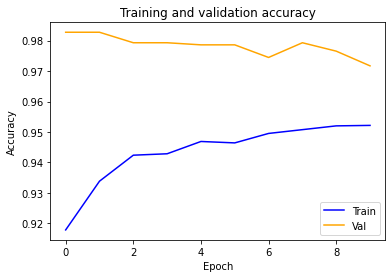

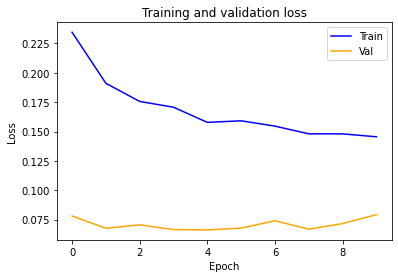

In [113]:
acc = multi_level_vgg_history.history['accuracy']
val_acc = multi_level_vgg_history.history['val_accuracy']
loss = multi_level_vgg_history.history['loss']
val_loss = multi_level_vgg_history.history['val_loss']


plt.title('Training and validation accuracy')
plt.plot(range(epochs), acc, color='blue', label='Train')
plt.plot(range(epochs), val_acc, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

_ = plt.figure()
plt.title('Training and validation loss')
plt.plot(range(epochs), loss, color='blue', label='Train')
plt.plot(range(epochs), val_loss, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [114]:
print("Evaluate on test data")
results = vgg_multi_resolution_model.evaluate(multi_test_generator, steps = test_df.shape[0]//batch_size)
print("test loss, test acc:", results)

Evaluate on test data
Found 1274 validated image filenames belonging to 2 classes.
Found 1274 validated image filenames belonging to 2 classes.
159/159 [==============================] - 11s 67ms/step - loss: 0.3836 - accuracy: 0.8648
test loss, test acc: [0.3836168646812439, 0.8647798895835876]


In [116]:
predictions = vgg_multi_resolution_model.predict(multi_test_generator, steps = test_df.shape[0]//batch_size)
tumor_prob = predictions[:,1]
y_pred = np.round(tumor_prob)
# y_pred = np.argmax(predictions, axis=-1)
y_true = test_df.Labels[:len(y_pred)].values.astype('int')

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.90       840
           1       0.91      0.66      0.77       432

    accuracy                           0.86      1272
   macro avg       0.88      0.82      0.84      1272
weighted avg       0.87      0.86      0.86      1272



In [117]:
# vgg_multi_resolution_model.save('/content/multi_level_vgg_model.h5')

In [137]:
vgg_base_1.trainable = True
vgg_base_2.trainable = True

vgg_multi_resolution_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                                   loss = 'sparse_categorical_crossentropy',
                                   metrics = ['accuracy'])
vgg_multi_resolution_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential_14 (Sequential)      (None, 512)          14714688    input_31[0][0]                   
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 512)          14714688    input_32[0][0]                   
____________________________________________________________________________________________

In [138]:
epochs = 10
multi_level_vgg_history_tf = vgg_multi_resolution_model.fit(multi_train_generator, 
                                                          epochs = epochs,
                                                          steps_per_epoch = steps_per_epoch,
                                                          validation_steps = validation_steps,
                                                          validation_data=multi_val_generator,
                                                          callbacks=[vgg_checkpoint_callback, 
                                                                    vgg_early_stop_callback])

Epoch 1/10
805/805 [==============================] - 336s 416ms/step - loss: 0.3765 - accuracy: 0.8948 - val_loss: 0.0952 - val_accuracy: 0.9821
Epoch 2/10
805/805 [==============================] - 333s 413ms/step - loss: 0.3692 - accuracy: 0.8941 - val_loss: 0.0752 - val_accuracy: 0.9821
Epoch 3/10
805/805 [==============================] - 337s 420ms/step - loss: 0.2827 - accuracy: 0.8992 - val_loss: 0.0907 - val_accuracy: 0.9821
Epoch 4/10
805/805 [==============================] - 350s 436ms/step - loss: 0.2632 - accuracy: 0.9003 - val_loss: 0.0874 - val_accuracy: 0.9821
Epoch 5/10
805/805 [==============================] - 354s 439ms/step - loss: 0.2550 - accuracy: 0.9118 - val_loss: 0.0876 - val_accuracy: 0.9821
Epoch 6/10
805/805 [==============================] - 350s 435ms/step - loss: 0.2581 - accuracy: 0.9154 - val_loss: 0.0713 - val_accuracy: 0.9821
Epoch 7/10
805/805 [==============================] - 349s 434ms/step - loss: 0.1950 - accuracy: 0.9392 - val_loss: 0.0788 -

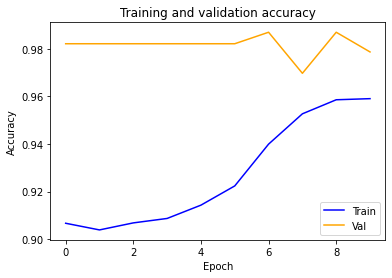

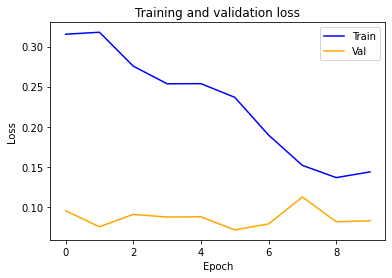

In [140]:
acc = multi_level_vgg_history_tf.history['accuracy']
val_acc = multi_level_vgg_history_tf.history['val_accuracy']
loss = multi_level_vgg_history_tf.history['loss']
val_loss = multi_level_vgg_history_tf.history['val_loss']


plt.title('Training and validation accuracy')
plt.plot(range(epochs), acc, color='blue', label='Train')
plt.plot(range(epochs), val_acc, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

_ = plt.figure()
plt.title('Training and validation loss')
plt.plot(range(epochs), loss, color='blue', label='Train')
plt.plot(range(epochs), val_loss, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [141]:
print("Evaluate on test data")
results = vgg_multi_resolution_model.evaluate(multi_test_generator, steps = test_df.shape[0]//batch_size)
print("test loss, test acc:", results)

Evaluate on test data
159/159 [==============================] - 11s 69ms/step - loss: 0.2231 - accuracy: 0.8868
test loss, test acc: [0.22306832671165466, 0.8867924809455872]


In [142]:
predictions = vgg_multi_resolution_model.predict(multi_test_generator, steps = test_df.shape[0]//batch_size)
tumor_prob = predictions[:,1]
y_pred = np.round(tumor_prob)
# y_pred = np.argmax(predictions, axis=-1)
y_true = test_df.Labels[:len(y_pred)].values.astype('int')

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       840
           1       0.99      0.67      0.80       432

    accuracy                           0.89      1272
   macro avg       0.92      0.83      0.86      1272
weighted avg       0.90      0.89      0.88      1272

